<a href="https://colab.research.google.com/github/SLKS99/Understanding-the-Ligand-Assisted-Reprecipitation-of-CsPbBr3-Perovskite-Nanocrystals-via-High-Throug/blob/main/Hand_mixed_CsPbBr3_Gaussian_fit_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import Modules 

import os
import glob
import numpy as np
import pandas as pd

#Machine Learning Tools
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#Peak Finding
from scipy.stats import norm, multivariate_normal
import scipy.signal as ss

#Plotting Tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

#gdown Installation
!pip install gdown==3.6.0

!pip install lmfit

from lmfit.models import GaussianModel, ExponentialModel, ConstantModel
import lmfit

from lmfit import Model
from lmfit import minimize
from numpy import exp, pi, sqrt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gdown: filename=gdown-3.6.0-py3-none-any.whl size=5235 sha256=262dd26fa9a92de9b1e17d33c217c420dd150e0fd118b5b1481b687ef79bdcd1
  Stored in directory: /root/.cache/pip/wheels/65/87/ec/f2fb412981ea66b391d86be88d414a09d93d75a7b37e4c7554
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 5.9 MB/s eta 0:00:00


## User Input

In [12]:
#@title Experimental Data 

#Names of Precursors
precursor1 = '$CsPbBr_3$' #@param {type:"string"}


#Wells that we should ignore
wells_to_ignore = 'A3,A6,A7,A8,A9,A10,A11,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,A12,B12,C12,D12,E12,F12,G12,H12' #@param {type:"string"}

#Information about Measurement Range
start_wavelength = 400 #@param {type:"integer"}
end_wavelength =  650 #@param {type:"integer"}
wavelength_step_size =  2 #@param {type:"integer"}

time_step = 9 #@param {type:"integer"}

#Information about the reads
number_of_reads =  1 #@param {type:"integer"}
luminescence_read_numbers = '1'
#3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92'
#,93,94,95,96,97,98,99,100,101,102,103' #@param {type:"string"}

#Convert the string into a list to use later 
if len(wells_to_ignore) != 0:
  wells_to_ignore = list(wells_to_ignore.split(","))
luminescence_read_numbers = list(luminescence_read_numbers.split(","))

In [13]:
#@title Data Information

#Name of files 
data_file_name = 'Hand mixed a10 A1.csv' #@param {type:'string'}
composition_file_name = 'CsPbBr3 wells.csv' #@param {type:'string'}

#Download the correct data
data_file = '1d_wr71Rfu2hefy3_ZSBSo-O4u_jjO81k' #@param {type:"string"}
composition_file = '1inVFp-FtwBxsHCaDJRrarAAshRtmyFV6' #@param {type:"string"}

## Downloading and Formating Data

In [28]:
#@title Download Files

!gdown https://drive.google.com/uc?id={data_file}

!gdown https://drive.google.com/uc?id={composition_file}

Downloading...
From: https://drive.google.com/uc?id=1d_wr71Rfu2hefy3_ZSBSo-O4u_jjO81k
To: /content/Hand mixed a10 A1.csv
100% 3.75k/3.75k [00:00<00:00, 6.50MB/s]
Downloading...
From: https://drive.google.com/uc?id=1inVFp-FtwBxsHCaDJRrarAAshRtmyFV6
To: /content/CsPbBr3 wells.csv
100% 1.08k/1.08k [00:00<00:00, 2.12MB/s]


In [29]:
#@title Into Pandas Dataframes
rawData = pd.read_csv(data_file_name,header=[0])
rawData = rawData.replace('OVRFLW', np.NaN)
rawData = rawData.replace(r'^\s*$', np.NaN, regex=True)
composition = pd.read_csv(composition_file_name, index_col = 0)



In [30]:
luminescence_wavelength=rawData['Wavelength']

In [24]:
rawData=rawData.drop(['Wavelength'],axis=1)
rawData

,A1,A2,A3,A4,A5,A6,A7,A8,A9,Unnamed: 10,Unnamed: 11
0,13,3,NaN,NaN,NaN,2,NaN,0,0,NaN,NaN
1,13,6,NaN,NaN,NaN,1,NaN,0,1,NaN,NaN
2,12,5,NaN,NaN,NaN,2,NaN,1,0,NaN,NaN
3,14,4,NaN,NaN,NaN,3,NaN,2,3,NaN,NaN
4,14,0,NaN,NaN,NaN,0,NaN,3,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
146,2,2,NaN,NaN,NaN,5,NaN,0,0,NaN,NaN
147,1,0,NaN,NaN,NaN,1,NaN,2,1,NaN,NaN
148,3,4,NaN,NaN,NaN,0,NaN,0,1,NaN,NaN
149,0,0,NaN,NaN,NaN,1,NaN,1,6,NaN,NaN


### Read One Gaussian Fit

In [25]:
Readone= np.array(rawData)
Readone

array([[13, 3, nan, ..., 0, nan, nan],
       [13, 6, nan, ..., 1, nan, nan],
       [12, 5, nan, ..., 0, nan, nan],
       ...,
       [3, 4, nan, ..., 1, nan, nan],
       [0, 0, nan, ..., 6, nan, nan],
       [0, 3, nan, ..., 0, nan, nan]], dtype=object)

{'amplitude': 15134.2823172126, 'center': 522.4708942117846, 'sigma': 10.600816391773924, 'fwhm': 24.963014455677072, 'height': 569.5509829944131}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 151
    # variables        = 3
    chi-square         = 17382.9479
    reduced chi-square = 117.452351
    Akaike info crit   = 722.640740
    Bayesian info crit = 731.692579
    R-squared          = 0.99329579
[[Variables]]
    amplitude:  15134.2823 +/- 115.070840 (0.76%) (init = 18975)
    center:     522.470894 +/- 0.09307038 (0.02%) (init = 523)
    sigma:      10.6008164 +/- 0.09307138 (0.88%) (init = 11)
    fwhm:       24.9630145 +/- 0.21916635 (0.88%) == '2.3548200*sigma'
    height:     569.550983 +/- 4.33049138 (0.76%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5774


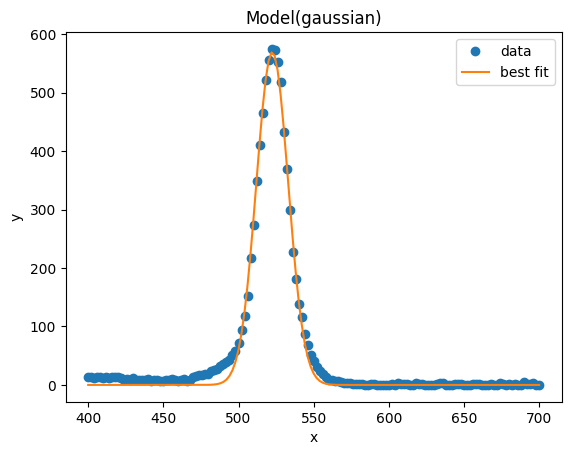

{'amplitude': 144976.69218120564, 'center': 521.018452560987, 'sigma': 11.214089130359326, 'fwhm': 26.40716136595275, 'height': 5157.559776173185}
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 151
    # variables        = 3
    chi-square         = 1130969.90
    reduced chi-square = 7641.68850
    Akaike info crit   = 1353.11725
    Bayesian info crit = 1362.16909
    R-squared          = 0.99504003
[[Variables]]
    amplitude:  144976.692 +/- 954.644118 (0.66%) (init = 186804)
    center:     521.018453 +/- 0.08526604 (0.02%) (init = 520)
    sigma:      11.2140891 +/- 0.08526696 (0.76%) (init = 12)
    fwhm:       26.4071614 +/- 0.20078834 (0.76%) == '2.3548200*sigma'
    height:     5157.55978 +/- 33.9616473 (0.66%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = +0.5774


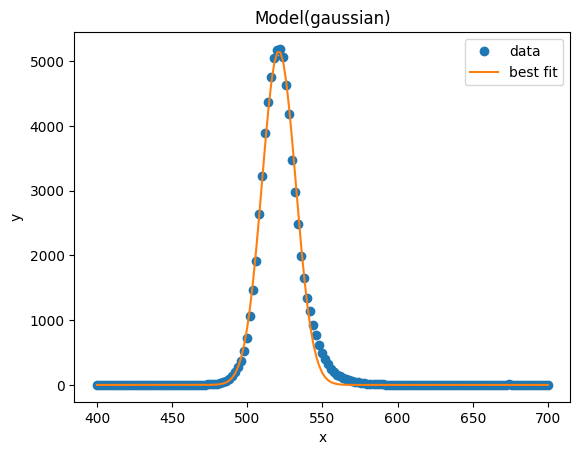

TypeError: ignored

In [31]:
# Note that this code is to play around. I did not optimize parameters here
# Optimized parameters are in Gauss4Fit function



data = Readone
result_readone= np.zeros((data.shape[0],data.shape[1],4))
x = luminescence_wavelength  #np.arange(dat.shape[0])


 
fwhm=[]
center=[]
height=[]
fit_data=[]
for i in range (4):
  y=data[:,i]
  mod = GaussianModel()
  pars = mod.guess(y, x=x)
  result = mod.fit(y, pars, x=x) 
  val= result.params.valuesdict()
  f= np.array(val['fwhm'])
  fwhm.append(f)
  c= np.array(val['center'])
  center.append(c)
  h=np.array(val['height'])
  height.append(h)
  #values= np.array(result.params.valuesdict())
  #fit_data.append(values)
  print(result.params.valuesdict())
  para=result.fit_report()
  print(result.fit_report())
  
  result.plot_fit()
      
      
  plt.show()
  
  



### Bar plot for Read One

##FWHM Bar Plot

In [33]:
fwhm_bar= pd.DataFrame(fwhm)
fwhm_bar.rename(columns={fwhm_bar.columns[0]: 'fwhm'},inplace=True)



print(fwhm_bar)

        fwhm
0  24.963014
1  26.407161


##Center Bar Plot for Read Initial

In [35]:
center_bar= pd.DataFrame(center)
center_bar.rename(columns={center_bar.columns[0]: 'center'},inplace=True)



print(center_bar)

       center
0  522.470894
1  521.018453
